In [1]:
!pip install dionysus
!pip install gudhi
!pip install networkx
!pip install persim
!pip install xarray
!pip install validclust
!pip install importlib-metadata==4.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dionysus: filename=dionysus-2.0.9-cp38-cp38-linux_x86_64.whl size=343402 sha256=cc0c3fbcf5350646834fc1469e6dd780143025a0f49aabc562f2aafaf2c597f9
  Stored in directory: /root/.cache/pip/wheels/68/78/85/6b72f8fb1321e7184a39bb9ab883b1fa459de1fdd203310e98
Successfully built dionysus
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.6/31.6 MB 33.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 KB 5.1 MB/s eta 0:00:00
  Preparing metadata (s

In [2]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/My Drive/NASA")
!ls -ltr

total 14438
-rw------- 1 root root    1667 Oct  5 18:53  zigzagtools.py
-rw------- 1 root root   85452 Oct  5 18:53  zigzag_PD_eps_1.pdf
-rw------- 1 root root       0 Oct  5 18:53  VRrips.pk
-rw------- 1 root root  133051 Oct  5 18:53  PIs_labelled_modulo_month.pdf
-rw------- 1 root root  132779 Oct  5 18:53  PIs_labelled_modulo_month_1.pdf
-rw------- 1 root root  105850 Oct  5 18:53  PIs_labelled_modulo_month_0.pdf
-rw------- 1 root root  127787 Oct  5 18:53  PIs_labelled_1.pdf
-rw------- 1 root root  116243 Oct  5 18:53  PIs_labelled_0.pdf
-rw------- 1 root root  253295 Oct  5 18:53  PClouds.pdf
-rw------- 1 root root 1682280 Oct  5 18:53  Merra_t2m_freudenthal_Oct_2022.ipynb
-rw------- 1 root root  324306 Oct  5 18:53  Merra_t2m_freudenthal.ipynb
-rw------- 1 root root  323836 Oct  5 18:53  MERRA2_t2m_GP_20210201-20210228.nc
-rw------- 1 root root 1690684 Oct  5 18:53  MERRA2_t2m_CONUS_20210201-20210228.nc
-rw------- 1 root root  527019 Oct  5 18:53  MERRA2_t2m_CONUS_20210201-20210

In [4]:
from __future__ import print_function
import pickle
#import zigzagtools as zzt
import numpy as np
from numpy import linalg as LA
import pandas as pd
#import networkx as nx
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import dionysus as d
import matplotlib.pyplot as plt
import time
import netCDF4
import numpy as np
import gudhi as gd
#import networkx as nx
from persim import PersImage
import sys
import time
from validclust import dunn, cop, ValidClust
import itertools

In [5]:
!pip install POT==0.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 KB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for POT: filename=POT-0.5.1-cp38-cp38-linux_x86_64.whl size=319864 sha256=776068cdc0bbd08660d27ca3af223ddbab22c4726593aabba93abc8f54950910
  Stored in directory: /root/.cache/pip/wheels/ce/ad/64/419a440d8dff2a71e2ffbd512a4ae8ae66e89918044da4afe9
Successfully built POT


In [6]:
import os
# added
import ot
from gudhi.wasserstein import wasserstein_distance as wd
#import regrid_hp as rhp
#import cartopy.crs as ccrs
#import healpy as hp
import xarray as xr
import mpl_toolkits
#from cartopy.io import shapereader
#from mpl_toolkits.basemap import Basemap
#import ocw.utils as utils
#import ocw.data_source.local as local
#import ocw.dataset_processor as dsp
#from ocw.dataset import Bounds as Bounds
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from persim import wasserstein
from sklearn.cluster import DBSCAN
import seaborn as sns
sns.set_theme()

In [7]:
path = os.getcwd()
#%% Parameters 
#nameFolderCloud = path + '/PointCloud/5_Dimensions/datafullpc'  # Example 1 (Dorcas)  (sizeWindow = 10) * It has not any interesting structures
#nameFolderCloud = path + '/PointCloud/FIG8Saved_40/File'  # Example 2  (sizeWindow = 12)
#nameFolderCloud = path + '/../Example_POINT_CLOUD/PointCloud/FIG8Saved_60/File'  # Example 3  (sizeWindow = 12)
#scaleParameter = 1.0 # [Example 2 and 3] Maximum Scale Parameter for Filtration (Depends on distance between points)
#scaleParameter = 9.0 # [Example 1] Maximum Scale Parameter for Filtration (Depends on distance between points)
maxDimHoles = 2 # Maximum Dimension of Holes (It means.. 0 and 1)
sizeWindow = 28 # [Example 2 and 3] Number of Point-Clouds (i.e. timestamps) 
#sizeWindow = 10 # [Example 1] Number of Point-Clouds (i.e. timestamps) 

In [8]:
def extract_PD_arrays_with_cubical_complex(data, infinity = 300.):
    cubical_complex = gd.CubicalComplex(top_dimensional_cells=data)
    PD_CC = cubical_complex.persistence()
    dim = np.array([i[0] for i in PD_CC])
    birth = np.array([i[1][0] for i in PD_CC])
    death = np.array([i[1][1] for i in PD_CC])
    death[death==np.Infinity] = infinity
    n0 = dim[dim==0].size
    n1 = dim[dim==1].size
    pd0 = np.zeros([n0, 2])
    pd1 = np.zeros([n1, 2])
    pd0[:,0] = birth[dim==0]
    pd0[:,1] = death[dim==0]
    pd1[:,0] = birth[dim==1]
    pd1[:,1] = death[dim==1]
    return cubical_complex, pd0, pd1

def calculate_wasserstein_distance(pd0_array1, pd0_array2, pd1_array1, pd1_array2, order=2):
    return wd(pd0_array1, pd0_array2, order=order) + wd(pd1_array1, pd1_array2, order=order)

In [9]:
def extract_PD_arrays_with_freudenthal_triangulation(data, lower =240., infinity = 300.):
    
    f_lower_star = d.fill_freudenthal(np.array(data, dtype='float64'))
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    birth0=np.array([dgm.birth for dgm in dgms[0]])
    death0=np.array([dgm.death for dgm in dgms[0]])
    death0[death0==np.Infinity] = infinity 
    birth1=np.array([dgm.birth for dgm in dgms[1]])
    death1=np.array([dgm.death for dgm in dgms[1]])
    death1[death1==np.Infinity] = infinity
   
    return [[birth0,death0],[birth1,death1]]

In [10]:
def plot_PDs (pd0_array, pd1_array, titles, lower_bound=240, upper_bound=300):
    fig = plt.figure(figsize=(25,15))
    nday = len(pd0_array)
    for iday in np.arange(nday):
        ax = fig.add_subplot(4,7,1+iday)
        ax.scatter(pd0_array[iday][:,0], pd0_array[iday][:,1], color='r', s=5, label = '0')
        ax.scatter(pd1_array[iday][:,0], pd1_array[iday][:,1], marker='^', s=5,
               facecolors='none', edgecolor='blue', label = '1')
        
        ax.plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
        ax.set_xlim([lower_bound, upper_bound])
        ax.set_ylim([lower_bound, upper_bound])
        ax.set_title(titles[iday])
        #ax.set_xlabel('Birth')
        #ax.set_ylabel('Death')
        #ax.set_xticks(np.arange(4)*20+240)
        #ax.set_xticklabels(np.repeat('',4))
        #ax.set_yticks(np.arange(4)*20+240)
        #ax.set_yticklabels(np.repeat('',4))

In [11]:
def plot_Dionysus_PDs(pd0_array, pd1_array, titles, lower_bound=240, upper_bound=300):
    fig = plt.figure(figsize=(30,20))
    nday = len(pd0_array)
    for iday in np.arange(nday):
        ax = fig.add_subplot(4,7,1+iday)
        ax.scatter(pd0_array[iday][0], pd0_array[iday][1], color='r', s=5, label = '0')
        ax.scatter(pd1_array[iday][0], pd1_array[iday][1], marker='^', s=5,
               facecolors='none', edgecolor='blue', label = '1')
        
        ax.plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
        ax.set_xlim([lower_bound, upper_bound])
        ax.set_ylim([lower_bound, upper_bound])
        ax.set_title(titles[iday])
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death')
    plt.savefig("pds.pdf",bbox_inches='tight')
    plt.show()   
        

In [12]:
def plot_Dionysus_PDs_by_Cluster(pd0_array, pd1_array, titles, cluster_labels, lower_bound=240, upper_bound=300):
    fig = plt.figure(figsize=(30,20))
    nday = len(pd0_array)
    idx0= np.where(cluster_labels==0)[0]
    idx1= np.where(cluster_labels==1)[0]
    
    ax = fig.add_subplot(2,2,1)
    for iday in idx0:    
        ax.scatter(pd0_array[iday][0], pd0_array[iday][1], color='r', s=5, label = '0')
    ax = fig.add_subplot(2,2,2)
    for iday in idx0:    
        ax.scatter(pd1_array[iday][0], pd1_array[iday][1], marker='^', s=5,
            facecolors='none', edgecolor='blue', label = '1')
        
    ax.plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
    ax.set_xlim([lower_bound, upper_bound])
    ax.set_ylim([lower_bound, upper_bound])
    #ax.set_title(titles[iday])
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    
    ax = fig.add_subplot(2,2,3)
    for iday in idx1:    
        ax.scatter(pd0_array[iday][0], pd0_array[iday][1], color='r', s=5, label = '0')
    ax = fig.add_subplot(2,2,4)
    for iday in idx1:    
        ax.scatter(pd1_array[iday][0], pd1_array[iday][1], marker='^', s=5,
               facecolors='none', edgecolor='blue', label = '1')
        
    ax.plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
    ax.set_xlim([lower_bound, upper_bound])
    ax.set_ylim([lower_bound, upper_bound])
    #ax.set_title(titles[iday])
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')

In [13]:
'''
f = netCDF4.Dataset('MERRA2_t2m_CONUS_20210201-20210228_hp05.nc', 'r')
print(f)
'''
fname = 'MERRA2_t2m_GP_20210201-20210228.nc'
ds = xr.open_dataset(fname)
data = ds['t2m'].squeeze()
nday = 28
lon = ds.lon
lat = ds.lat
#print(data.min(), data.max())
#print (np.shape(data[0,:]))
#print (data[0,:])

p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(data[0,:])
#print (p0)
print (data[0,:, :])

<xarray.DataArray 't2m' (y: 41, x: 33)>
[1353 values with dtype=float64]
Coordinates:
    time     datetime64[ns] 2021-06-16
Dimensions without coordinates: y, x


In [14]:
print (lon)

<xarray.DataArray 'lon' (x: 33)>
[33 values with dtype=float64]
Dimensions without coordinates: x


In [ ]:
#dataset = local.load_file(fname, 't2m')

In [15]:

innerSizeWindow=7
lower=int(np.floor(innerSizeWindow/2))
upper=int(np.ceil(innerSizeWindow/2))

In [16]:
# plot 7 day t2m averages

In [17]:
#freudenthal_complex = []
pd0 = []
pd1 = []

#freudenthal_complex_union = []
pd0_union = []
pd1_union = []
for iday in np.arange(nday):
    # Build freudenthal_triangulation for individual day 
    p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(data[iday,:])
    #freudenthal_complex.append(cc)
    pd0.append(p0)
    pd1.append(p1)
    # Build freudenthal_triangulation for the union of two consecutive days
    #if iday != nday-1:
    #p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(0.5*data[iday,:]+0.5*data[iday+1,:])
    p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(data[iday,:])
    
    #freudenthal_complex_union.append(cc)
    pd0_union.append(p0)
    pd1_union.append(p1)

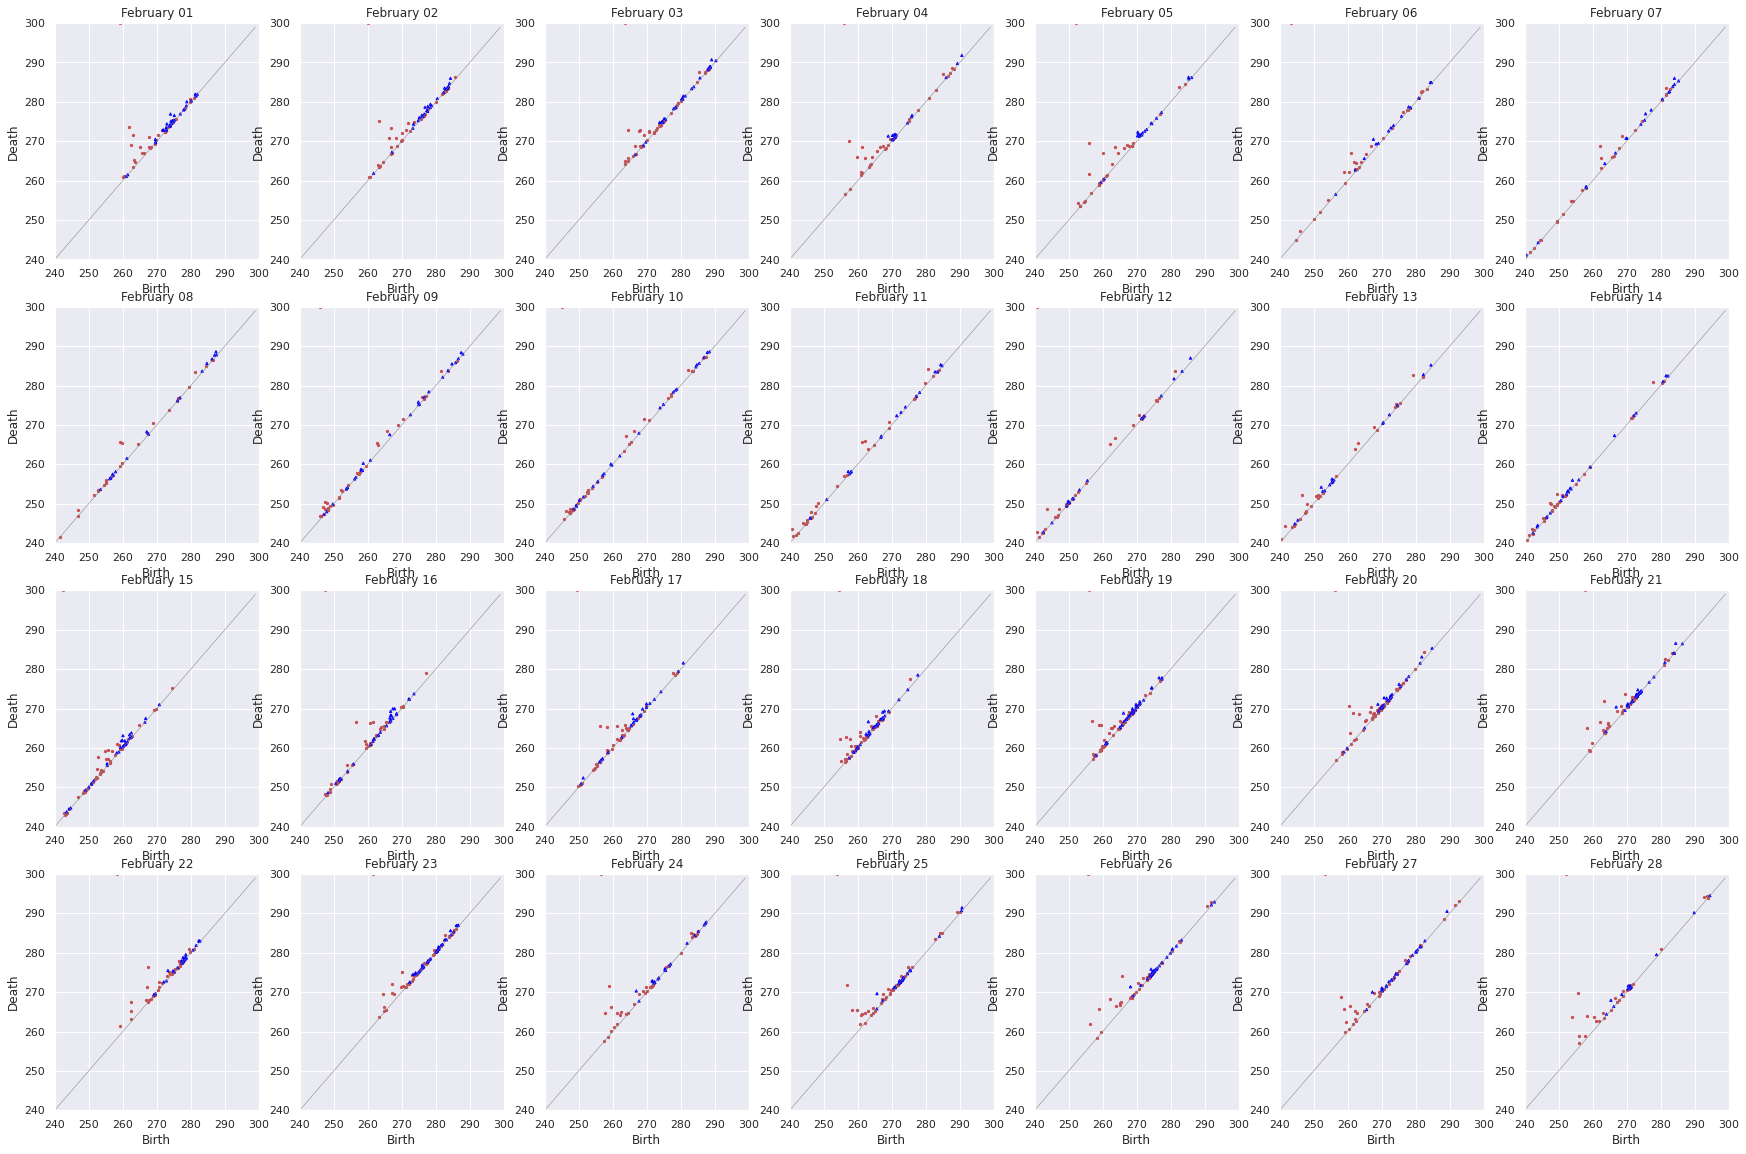

In [18]:
titles = ['February %02d' %(iday+1) for iday in np.arange(nday)]
plot_Dionysus_PDs(pd0_union, pd1_union, titles)

In [ ]:
## Note: you must run the clustering below first in order to obtain the labels with the "best" method

In [ ]:
def optimalDBSCAN(data, score_, eps, metric='euclidean', bMax=True, distType=0):
    eps_range=np.arange(eps['min'],eps['max'],eps['inc'])
    min_samples_range=range(2,10)
    if bMax==True:
        best_score =-1e9
    else:
        best_score =1e9
        
    eps_ask=0
    min_samples_ask=0
    clustering_ask=None
    print("score, best_score, eps, eps_ask, min_samples, min_samples_ask")
    for min_samples in min_samples_range:
     for eps in eps_range:
      clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
      clustering.fit(data)
      if len(np.unique(clustering.labels_))>1:
        if distType==0:
            score=score_(data, clustering.labels_)
        elif distType==1:
            dist=pairwise_distances(data)
            score=score_(dist, clustering.labels_)
        elif distType==2:
            dist=pairwise_distances(data)
            score=score_(data, dist, clustering.labels_)
        if (score>best_score and bMax==True):
          best_score=score
          eps_ask=eps
          min_samples_ask=min_samples
          clustering_ask=clustering
        elif(score<best_score and bMax==False):
          best_score=score
          eps_ask=eps
          min_samples_ask=min_samples
          clustering_ask=clustering  
        print(score, best_score, eps, eps_ask, min_samples, min_samples_ask)
    return(best_score, eps_ask, min_samples_ask, clustering_ask)   

In [ ]:
def optimalHClust(data, score_, metric='euclidean', bMax=True, distType=0):
    if bMax==True:
        best_score =-1e9
    else:
        best_score =1e9
    linkage_ask = ''  
    n_ask = 2
    clustering_ask = None
    print("score, best_score, i, n_ask, linkage, linkage_ask")
    for i in range(2, 7):
     for linkage in ['complete', 'average', 'single']: 
      clustering= AgglomerativeClustering(n_clusters=i, affinity=metric, linkage=linkage)
      #clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
      clustering.fit(data)
      if len(np.unique(clustering.labels_))>1:
        if distType==0:
            score=score_(data, clustering.labels_)
        elif distType==1:
            dist=pairwise_distances(data)
            score=score_(dist, clustering.labels_)
        elif distType==2:
            dist=pairwise_distances(data)
            score=score_(data, dist, clustering.labels_)
        if (score>best_score and bMax==True):
          best_score=score
          linkage_ask=linkage
          n_ask=i
          clustering_ask=clustering
        elif(score<best_score and bMax==False):
          best_score=score
          linkage_ask=linkage
          n_ask=i 
          clustering_ask=clustering
        print(score, best_score, i, n_ask, linkage, linkage_ask)
    return(best_score, n_ask, linkage_ask, clustering_ask)

In [ ]:
results = {}
results['data'] = {}
results['pis']= {}
results['pds']= {}
params = {}
params['data'] = {}
params['pis']= {}
params['pds']= {}
clusters = {}
clusters['data'] = {}
clusters['pis']= {}
clusters['pds']= {}

In [ ]:
# Option 1
# Persistence image on our own
# resolution is the size of persistence image
def persistence_image(dgm, resolution = [50,50], return_raw = False, normalization = True, bandwidth = 1., power = 1.):
    PXs, PYs = dgm[:, 0:1], dgm[:, 1:2]
    xm, xM, ym, yM = PXs.min(), PXs.max(), PYs.min(), PYs.max()
    x = np.linspace(xm, xM, resolution[0])
    y = np.linspace(ym, yM, resolution[1])
    X, Y = np.meshgrid(x, y)
    Zfinal = np.zeros(X.shape)
    X, Y = X[:, :, np.newaxis], Y[:, :, np.newaxis]

    P0, P1 = np.reshape(dgm[:, 0], [1, 1, -1]), np.reshape(dgm[:, 1], [1, 1, -1])

    # Compute image
    weight = np.abs(P1 - P0)
    distpts = np.sqrt((X - P0) ** 2 + (Y - P1) ** 2)

    if return_raw:
        lw = [weight[0, 0, pt] for pt in range(weight.shape[2])]
        lsum = [distpts[:, :, pt] for pt in range(distpts.shape[2])]
    else:
        weight = weight ** power
        Zfinal = (np.multiply(weight, np.exp(-distpts ** 2 / bandwidth))).sum(axis=2)

    output = [lw, lsum] if return_raw else Zfinal

    if normalization:
        norm_output = (output - np.min(output)) / (np.max(output) - np.min(output))
    else:
        norm_output = output

    return norm_output

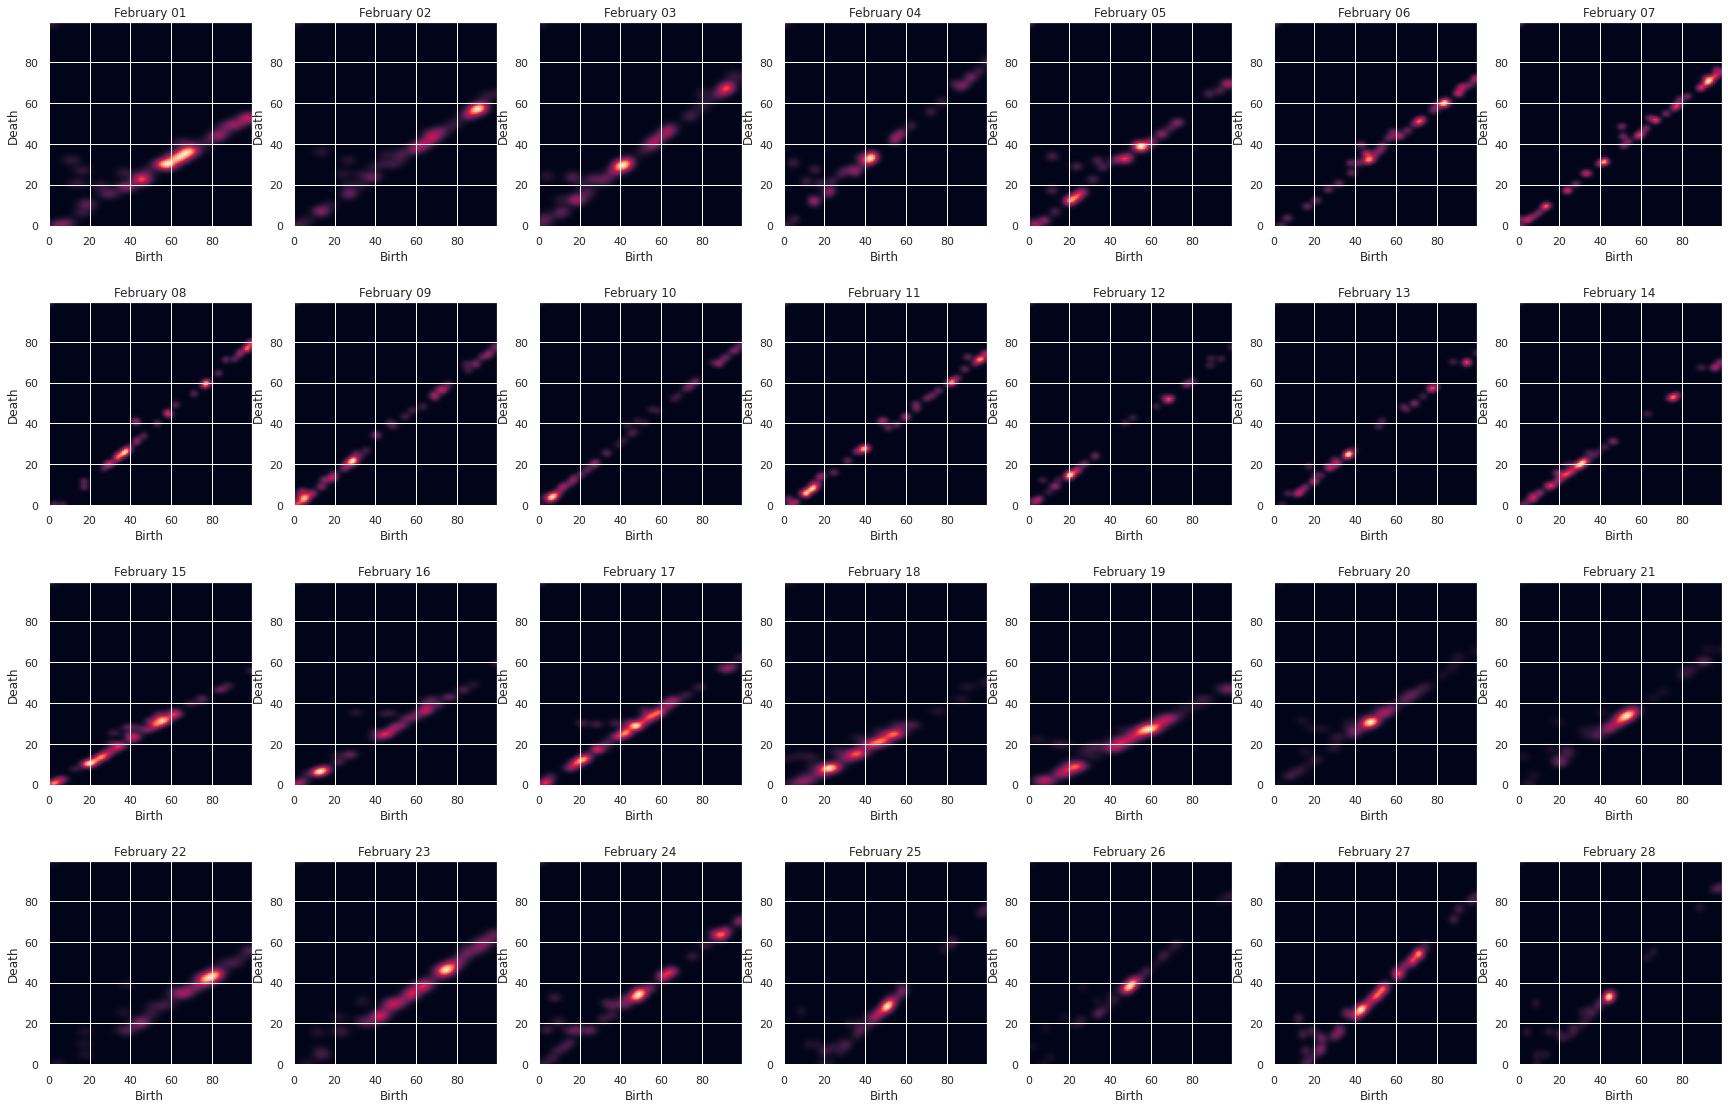

In [ ]:
PIs = []
fig = plt.figure(figsize=(30,30))

for iday in np.arange(nday):
    ax = fig.add_subplot(6,7,1+iday)
    xs= np.concatenate((pd0[iday][0][:], pd1[iday][0][:]), axis=0)
    ys= np.concatenate((pd0[iday][1][:], pd1[iday][1][:]), axis=0)
    D = np.transpose([xs,ys])
    PI = persistence_image(D, resolution =(100,100), power=0.01)
    ax.imshow(PI, origin='lower')
    ax.set_title(titles[iday])
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    PIs.append(PI.flatten())
plt.savefig('pis.pdf', bbox_inches='tight')
plt.show()    

In [ ]:
X = np.array(PIs)
X -= np.min(X)
X/= (np.max(X)-np.min(X))

In [ ]:
vclust = ValidClust(
    k=list(range(2, 8)),
    methods=['hierarchical', 'kmeans'],
    indices=['silhouette', 'calinski', 'davies', 'dunn', 'cop']
)
cvi_vals = vclust.fit_predict(X)
print(cvi_vals)

                                2         3         4         5         6  \
method       index                                                          
hierarchical silhouette  0.135201  0.146139  0.170221  0.122998  0.128438   
             calinski    5.291501  5.183652  4.614478  4.297323  4.047846   
             davies      2.188574  1.846436  1.532884  1.654996  1.587269   
             dunn        0.459894  0.515063  0.568151  0.568151  0.572035   
             cop         0.439007  0.452429  0.433110  0.462301  0.452404   
kmeans       silhouette  0.157951  0.161217  0.104750  0.102929  0.107055   
             calinski    5.430181  4.733128  4.097853  3.779523  3.735157   
             davies      2.128576  1.736128  1.869765  1.387009  1.707955   
             dunn        0.557509  0.493273  0.493273  0.568151  0.569530   
             cop         0.440012  0.440400  0.469162  0.487810  0.444682   

                                7  
method       index                 
hie

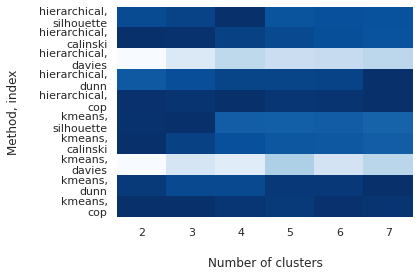

In [ ]:
vclust.plot()

In [ ]:
keys = cvi_vals[2]['kmeans'].keys()
for method in ['hierarchical','kmeans']:
 results['pis'][method]={}   
 for key in keys:
  if key=='davies':  
    idx=np.argmin([cvi_vals[x][method][key] for x in range(2,7)])
  else:
    idx=np.argmax([cvi_vals[x][method][key] for x in range(2,7)])
  #print(cvi_vals[2+idx][method][key])
  results['pis'][method][key]=cvi_vals[2+idx][method][key]

In [ ]:
#Convert to wasserstein distance
wdist = np.zeros((nday,nday))
for i in range(nday):
  for j in range(i+1):
    wdist[i,j] = wd(X[i,].reshape(1,10000), X[j,].reshape(1,10000), order=2) #wasserstein(Di, Dj) # where the format of PD is numpy matrix
    wdist[j,i] = wdist[i,j]

In [ ]:
wdist=(wdist-np.min(wdist))/(np.max(wdist)-np.min(wdist))

In [ ]:
eps={'min':0.01, 'max':10, 'inc': 0.05}
results['pis']['DBSCAN']={}
params['pis']['DBSCAN']={}
clusters['pis']['DBSCAN'] = {}

In [ ]:
scores=['silhouette', 'calinski', 'davies', 'dunn', 'cop']
bMax= True
distType=0
for score in scores:
    print('======' + score + '======' )
    if(score=='silhouette'):
        f= lambda data, labels: silhouette_score(data, labels)
    elif(score=='calinski'):
        f= lambda data, labels: calinski_harabasz_score(data, labels)
    elif(score=='davies'):
        f= lambda data, labels: davies_bouldin_score(data, labels)
        bMax=False
    elif(score == 'dunn'):
        f= lambda dist, labels: dunn(dist, labels)
        distType =1
    elif(score == 'cop'):
        f= lambda data, dist, labels: cop(data, dist, labels)
        distType =2
    results['pis']['DBSCAN'][score] = {}
    params['pis']['DBSCAN'][score] = {}
    clusters['pis']['DBSCAN'][score] = {}
    #[score_, eps_, min_samples_, clusters_]= optimalDBSCAN(data=X, score_=f, eps=eps, metric='euclidean', bMax=bMax, distType=distType)
    [score_, eps_, min_samples_, clusters_]= optimalDBSCAN(data=wdist, score_=f, eps=eps, metric='precomputed', bMax=bMax, distType=distType)
    
    results['pis']['DBSCAN'][score]= score_
    params['pis']['DBSCAN'][score]['eps'] = eps_
    params['pis']['DBSCAN'][score]['min_samples'] = min_samples_
    clusters['pis']['DBSCAN'][score] = clusters_
        

======silhouette======
score, best_score, eps, eps_ask, min_samples, min_samples_ask
-0.07737048437941399 -0.07737048437941399 0.01 0.01 2 2
0.04314808674960725 0.04314808674960725 0.060000000000000005 0.060000000000000005 2 2
0.2255043092945149 0.2255043092945149 0.11 0.11 2 2
0.40878018406555033 0.40878018406555033 0.16000000000000003 0.16000000000000003 2 2
0.4892485593123789 0.4892485593123789 0.21000000000000002 0.21000000000000002 2 2
0.5113981756400726 0.5113981756400726 0.26 0.26 2 2
0.5592716374422532 0.5592716374422532 0.31000000000000005 0.31000000000000005 2 2
0.5741521899398093 0.5741521899398093 0.36000000000000004 0.36000000000000004 2 2
0.5981371721608831 0.5981371721608831 0.41000000000000003 0.41000000000000003 2 2
0.5981371721608831 0.5981371721608831 0.46 0.41000000000000003 2 2
0.586616335796533 0.5981371721608831 0.51 0.41000000000000003 2 2
0.5778963969137694 0.5981371721608831 0.56 0.41000000000000003 2 2
0.600257290960532 0.600257290960532 0.6100000000000001 0.

In [ ]:
results['pis']['Hierarchical']={}
params['pis']['Hierarchical']={}
clusters['pis']['Hierarchical'] = {}

In [ ]:
scores=['silhouette', 'calinski', 'davies', 'dunn','cop']
bMax= True
distType=0
for score in scores:
    print('======' + score + '======' )
    if(score=='silhouette'):
        f= lambda data, labels: silhouette_score(data, labels)
    elif(score=='calinski'):
        f= lambda data, labels: calinski_harabasz_score(data, labels)
    elif(score=='davies'):
        f= lambda data, labels: davies_bouldin_score(data, labels)
        bMax=False
    elif(score == 'dunn'):
        f= lambda dist, labels: dunn(dist, labels)
        distType =1
    elif(score == 'cop'):
        f= lambda data, dist, labels: cop(data, dist, labels)
        distType =2
    results['pis']['Hierarchical'][score] = {}
    params['pis']['Hierarchical'][score] = {}
    clusters['pis']['Hierarchical'][score] = {}
    [score_, n, linkage, clusters_] = optimalHClust(data=wdist, score_=f, metric='precomputed', bMax=bMax, distType=distType)
    results['pis']['Hierarchical'][score]=score_
    params['pis']['Hierarchical'][score]['n']=n
    params['pis']['Hierarchical'][score]['linkage']=linkage
    clusters['pis']['Hierarchical'][score]=clusters_

======silhouette======
score, best_score, i, n_ask, linkage, linkage_ask
0.600257290960532 0.600257290960532 2 2 complete complete
0.600257290960532 0.600257290960532 2 2 average complete
0.600257290960532 0.600257290960532 2 2 single complete
0.4728969514060917 0.600257290960532 3 2 complete complete
0.4728969514060917 0.600257290960532 3 2 average complete
0.4728969514060917 0.600257290960532 3 2 single complete
0.45280788050976817 0.600257290960532 4 2 complete complete
0.45280788050976817 0.600257290960532 4 2 average complete
0.45280788050976817 0.600257290960532 4 2 single complete
0.4589390766281625 0.600257290960532 5 2 complete complete
0.4589390766281625 0.600257290960532 5 2 average complete
0.4589390766281625 0.600257290960532 5 2 single complete
0.44512891404567617 0.600257290960532 6 2 complete complete
0.44512891404567617 0.600257290960532 6 2 average complete
0.44512891404567617 0.600257290960532 6 2 single complete
======calinski======
score, best_score, i, n_ask, link

In [ ]:
results

{'data': {},
 'pis': {'hierarchical': {'silhouette': 0.17022055713136705,
   'calinski': 5.291501087241419,
   'davies': 1.5328839582389548,
   'dunn': 0.5720345311461305,
   'cop': 0.4623006040705178},
  'kmeans': {'silhouette': 0.1612167003549649,
   'calinski': 5.430180992449011,
   'davies': 1.387008631179033,
   'dunn': 0.5695303404511292,
   'cop': 0.48780959827292836},
  'DBSCAN': {'silhouette': 0.600257290960532,
   'calinski': 38.63670298311431,
   'davies': 0.24872380988583936,
   'dunn': 0.009907113264411729,
   'cop': 0.14276888644293745},
  'Hierarchical': {'silhouette': 0.600257290960532,
   'calinski': 13.51055235025921,
   'davies': 0.24872380988583936,
   'dunn': 0.5143416455432303,
   'cop': 0.19631183672767588}},
 'pds': {}}

In [ ]:
X = []
dim=np.shape(data[0,:])
for iday in np.arange(nday):
    X.append(np.array(data[iday,:]).reshape(dim[0]*dim[1]))

In [ ]:
X -= np.min(X)
X/= (np.max(X)-np.min(X))

In [ ]:
vclust = ValidClust(
    k=list(range(2, 8)),
    methods=['hierarchical', 'kmeans'],
    indices=['silhouette', 'calinski', 'davies', 'dunn', 'cop']
)
cvi_vals = vclust.fit_predict(X)
print(cvi_vals)

                                 2          3          4          5  \
method       index                                                    
hierarchical silhouette   0.521595   0.439905   0.435360   0.330981   
             calinski    49.574295  36.962779  33.482432  33.519855   
             davies       0.698612   0.909014   0.720603   0.965613   
             dunn         0.379480   0.272491   0.300117   0.409929   
             cop          0.203394   0.262875   0.257252   0.280972   
kmeans       silhouette   0.521595   0.447002   0.413808   0.321744   
             calinski    49.574295  37.139593  35.856872  32.806541   
             davies       0.698612   0.938938   0.802362   0.985406   
             dunn         0.379480   0.168777   0.356849   0.313756   
             cop          0.203394   0.253937   0.251277   0.279451   

                                 6          7  
method       index                             
hierarchical silhouette   0.312079   0.283967  
   

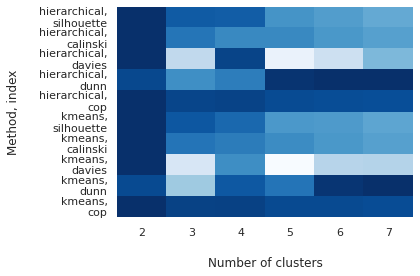

In [ ]:
vclust.plot()

In [ ]:
keys = cvi_vals[2]['kmeans'].keys()
for method in ['hierarchical','kmeans']:
 results['data'][method]={}   
 for key in keys:
  if key=='davies':  
    idx=np.argmin([cvi_vals[x][method][key] for x in range(2,7)])
  else:
    idx=np.argmax([cvi_vals[x][method][key] for x in range(2,7)])
  #print(cvi_vals[2+idx][method][key])
  results['data'][method][key]=cvi_vals[2+idx][method][key]

In [ ]:
#Convert to wasserstein distance
wdist = np.zeros((nday,nday))
for i in range(nday):
  for j in range(i+1):
    wdist[i,j] = wd(X[i,].reshape(1,1353), X[j,].reshape(1,1353), order=2) #wasserstein(Di, Dj) # where the format of PD is numpy matrix
    wdist[j,i] = wdist[i,j]

In [ ]:
wdist=(wdist-np.min(wdist))/(np.max(wdist)-np.min(wdist))

In [ ]:
eps={'min':0.01, 'max':10, 'inc': 0.05}
results['data']['DBSCAN']={}
params['data']['DBSCAN']={}
clusters['data']['DBSCAN']={}

In [ ]:
scores=['silhouette', 'calinski', 'davies', 'dunn', 'cop']
bMax= True
distType=0
for score in scores:
    print('======' + score + '======' )
    if(score=='silhouette'):
        f= lambda data, labels: silhouette_score(data, labels)
    elif(score=='calinski'):
        f= lambda data, labels: calinski_harabasz_score(data, labels)
    elif(score=='davies'):
        f= lambda data, labels: davies_bouldin_score(data, labels)
        bMax=False
    elif(score == 'dunn'):
        f= lambda dist, labels: dunn(dist, labels)
        distType =1
    elif(score == 'cop'):
        f= lambda data, dist, labels: cop(data, dist, labels)
        distType =2
    results['data']['DBSCAN'][score] = {}
    params['data']['DBSCAN'][score] = {}
    clusters['data']['DBSCAN'][score] = {}
    #[score_, eps_, min_samples_, clusters_]= optimalDBSCAN(data=X, score_=f, eps=eps, metric='euclidean', bMax=bMax, distType=distType)
    [score_, eps_, min_samples_, clusters_]= optimalDBSCAN(data=wdist, score_=f, eps=eps, metric='precomputed', bMax=bMax, distType=distType)
    
    results['data']['DBSCAN'][score]= score_
    params['data']['DBSCAN'][score]['eps'] = eps_
    params['data']['DBSCAN'][score]['min_samples'] = min_samples_
    clusters['data']['DBSCAN'][score]= clusters_
    
    #results['data']['DBSCAN'][score]= optimalDBSCAN(data=X, score_=f, eps=eps, metric='euclidean', bMax=bMax, distType=distType)

======silhouette======
score, best_score, eps, eps_ask, min_samples, min_samples_ask
-0.21048024920194439 -0.21048024920194439 0.01 0.01 2 2
0.03977933385372313 0.03977933385372313 0.060000000000000005 0.060000000000000005 2 2
0.12179727579062745 0.12179727579062745 0.11 0.11 2 2
0.29870473419089105 0.29870473419089105 0.16000000000000003 0.16000000000000003 2 2
0.36614925049743713 0.36614925049743713 0.21000000000000002 0.21000000000000002 2 2
0.4659123383058362 0.4659123383058362 0.26 0.26 2 2
0.593770355870622 0.593770355870622 0.31000000000000005 0.31000000000000005 2 2
0.625881514321774 0.625881514321774 0.36000000000000004 0.36000000000000004 2 2
0.6650740302186111 0.6650740302186111 0.41000000000000003 0.41000000000000003 2 2
0.6650740302186111 0.6650740302186111 0.46 0.41000000000000003 2 2
0.6561848259612046 0.6650740302186111 0.51 0.41000000000000003 2 2
0.6561848259612046 0.6650740302186111 0.56 0.41000000000000003 2 2
0.6561848259612046 0.6650740302186111 0.6100000000000001

In [ ]:
results['data']['Hierarchical']={}
params['data']['Hierarchical']={}
clusters['data']['Hierarchical'] = {}

In [ ]:
scores=['silhouette', 'calinski', 'davies', 'dunn','cop']
bMax= True
distType=0
for score in scores:
    print('======' + score + '======' )
    if(score=='silhouette'):
        f= lambda data, labels: silhouette_score(data, labels)
    elif(score=='calinski'):
        f= lambda data, labels: calinski_harabasz_score(data, labels)
    elif(score=='davies'):
        f= lambda data, labels: davies_bouldin_score(data, labels)
        bMax=False
    elif(score == 'dunn'):
        f= lambda dist, labels: dunn(dist, labels)
        distType =1
    elif(score == 'cop'):
        f= lambda data, dist, labels: cop(data, dist, labels)
        distType =2
    results['data']['Hierarchical'][score] = {}
    params['data']['Hierarchical'][score] = {}
    clusters['data']['Hierarchical'][score] = {}
    [score_, n, linkage, clusters_] = optimalHClust(data=wdist, score_=f, metric='precomputed', bMax=bMax, distType=distType)
    results['data']['Hierarchical'][score]=score_
    params['data']['Hierarchical'][score]['n']=n
    params['data']['Hierarchical'][score]['linkage']=linkage
    clusters['data']['Hierarchical'][score]=clusters_

======silhouette======
score, best_score, i, n_ask, linkage, linkage_ask
0.5363189511387255 0.5363189511387255 2 2 complete complete
0.5363189511387255 0.5363189511387255 2 2 average complete
0.5363189511387255 0.5363189511387255 2 2 single complete
0.5361322350925486 0.5363189511387255 3 2 complete complete
0.5361322350925486 0.5363189511387255 3 2 average complete
0.5361322350925486 0.5363189511387255 3 2 single complete
0.5418631265498568 0.5418631265498568 4 4 complete complete
0.5418631265498568 0.5418631265498568 4 4 average complete
0.5418631265498568 0.5418631265498568 4 4 single complete
0.5690191693869058 0.5690191693869058 5 5 complete complete
0.5690191693869058 0.5690191693869058 5 5 average complete
0.5690191693869058 0.5690191693869058 5 5 single complete
0.5078256307711916 0.5690191693869058 6 5 complete complete
0.5078256307711916 0.5690191693869058 6 5 average complete
0.5078256307711916 0.5690191693869058 6 5 single complete
======calinski======
score, best_score, i,

In [ ]:
results

{'data': {'hierarchical': {'silhouette': 0.5215945303475129,
   'calinski': 49.57429489130543,
   'davies': 0.6986123585737801,
   'dunn': 0.4166113207969418,
   'cop': 0.28649068395425636},
  'kmeans': {'silhouette': 0.5215945303475129,
   'calinski': 49.57429489130543,
   'davies': 0.6986123585737801,
   'dunn': 0.4099288216756018,
   'cop': 0.2794510289129823},
  'DBSCAN': {'silhouette': 0.6650740302186111,
   'calinski': 53.87953514089568,
   'davies': 0.2891755799317409,
   'dunn': 0.004973169400418938,
   'cop': 0.1594333486731887},
  'Hierarchical': {'silhouette': 0.5690191693869058,
   'calinski': 20.904087684822432,
   'davies': 0.20032212337377708,
   'dunn': 0.49916066413866783,
   'cop': 0.1571654140304303}},
 'pis': {'hierarchical': {'silhouette': 0.17022055713136705,
   'calinski': 5.291501087241419,
   'davies': 1.5328839582389548,
   'dunn': 0.5720345311461305,
   'cop': 0.4623006040705178},
  'kmeans': {'silhouette': 0.1612167003549649,
   'calinski': 5.430180992449011

In [ ]:
wdist = np.zeros((nday,nday))
for i in range(nday):
  xs= np.concatenate((pd0[i][0][:], pd1[i][0][:]), axis=0)
  ys= np.concatenate((pd0[i][1][:], pd1[i][1][:]), axis=0)
  Di = np.transpose([xs,ys])
   
  for j in range(i+1):
    #print(i,j)
    xs= np.concatenate((pd0[j][0][:], pd1[j][0][:]), axis=0)
    ys= np.concatenate((pd0[j][1][:], pd1[j][1][:]), axis=0)
    Dj = np.transpose([xs,ys])
  
    wdist[i,j] = wd(Di, Dj, order=2) #wasserstein(Di, Dj) # where the format of PD is numpy matrix
    wdist[j,i] = wdist[i,j]

In [ ]:
wdist=(wdist-np.min(wdist))/(np.max(wdist)-np.min(wdist))

In [ ]:
eps={'min':0.01, 'max':10, 'inc': 0.005}

In [ ]:
results['pds']['DBSCAN'] = {}
params['pds']['DBSCAN'] = {}
clusters['pds']['DBSCAN'] = {}

In [ ]:
scores=['silhouette', 'calinski', 'davies', 'dunn','cop']
bMax= True
distType=0
for score in scores:
    print('======' + score + '======' )
    if(score=='silhouette'):
        f= lambda data, labels: silhouette_score(data, labels)
    elif(score=='calinski'):
        f= lambda data, labels: calinski_harabasz_score(data, labels)
    elif(score=='davies'):
        f= lambda data, labels: davies_bouldin_score(data, labels)
        bMax=False
    elif(score == 'dunn'):
        f= lambda dist, labels: dunn(dist, labels)
        distType =1
    elif(score == 'cop'):
        f= lambda data, dist, labels: cop(data, dist, labels)
        distType =2
    results['pds']['DBSCAN'][score] = {}
    params['pds']['DBSCAN'][score] = {}
    clusters['pds']['DBSCAN'][score] = {}
    [score_, eps_, min_samples_, clusters_]= optimalDBSCAN(data=wdist, score_=f, eps=eps, metric='precomputed', bMax=bMax, distType=distType)
    results['pds']['DBSCAN'][score]= score_
    params['pds']['DBSCAN'][score]['eps'] = eps_
    params['pds']['DBSCAN'][score]['min_samples'] = min_samples_
    clusters['pds']['DBSCAN'][score] = clusters_
  

======silhouette======
score, best_score, eps, eps_ask, min_samples, min_samples_ask
0.024496221167537347 0.024496221167537347 0.155 0.155 2 2
0.15957904051096058 0.15957904051096058 0.15999999999999998 0.15999999999999998 2 2
0.15957904051096058 0.15957904051096058 0.16499999999999998 0.15999999999999998 2 2
0.15957904051096058 0.15957904051096058 0.16999999999999998 0.15999999999999998 2 2
0.21160682130105818 0.21160682130105818 0.175 0.175 2 2
-0.13608361921026182 0.21160682130105818 0.18 0.175 2 2
0.13542271731147285 0.21160682130105818 0.18499999999999997 0.175 2 2
0.13542271731147285 0.21160682130105818 0.18999999999999997 0.175 2 2
0.13542271731147285 0.21160682130105818 0.19499999999999998 0.175 2 2
0.17120388592105792 0.21160682130105818 0.19999999999999998 0.175 2 2
0.22605276341518712 0.22605276341518712 0.205 0.205 2 2
0.2238260589176277 0.22605276341518712 0.20999999999999996 0.205 2 2
0.1874678622261344 0.22605276341518712 0.21499999999999997 0.205 2 2
0.21847306400708355

In [ ]:
results['pds']['DBSCAN']

{'silhouette': 0.5974051673732811,
 'calinski': 66.43088491063959,
 'davies': 0.4989719455851414,
 'dunn': 0.09285696761338212,
 'cop': 0.19167725029442037}

In [ ]:
score='calinski'
clustering = DBSCAN(eps=params['pds']['DBSCAN'][score]['eps'], min_samples=params['pds']['DBSCAN'][score]['min_samples'], metric='precomputed')
clustering.fit(wdist)

DBSCAN(eps=0.27999999999999997, metric='precomputed', min_samples=6)

In [ ]:
clustering.labels_

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
for key in clusters['pds']['DBSCAN'].keys():
  print(key + "," + str(clusters['pds']['DBSCAN'][key].labels_))

silhouette,[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
calinski,[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
davies,[ 0  0 -1  0  0  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0
  0  0  0  0]
dunn,[-1 -1 -1 -1 -1 -1  0  0 -1 -1  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]
cop,[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
results['pds']['Hierarchical'] = {}
params['pds']['Hierarchical'] = {}
clusters['pds']['Hierarchical'] = {}

In [ ]:
scores=['silhouette', 'calinski', 'davies', 'dunn','cop'] #'cop'
bMax= True
distType=0
for score in scores:
    print('======' + score + '======' )
    if(score=='silhouette'):
        f= lambda data, labels: silhouette_score(data, labels)
    elif(score=='calinski'):
        f= lambda data, labels: calinski_harabasz_score(data, labels)
    elif(score=='davies'):
        f= lambda data, labels: davies_bouldin_score(data, labels)
        bMax=False
    elif(score == 'dunn'):
        f= lambda dist, labels: dunn(dist, labels)
        distType =1
    elif(score == 'cop'):
        f= lambda data, dist, labels: cop(data, dist, labels)
        distType =2
    results['pds']['Hierarchical'][score] = {}
    params['pds']['Hierarchical'][score] = {}
    clusters['pds']['Hierarchical'][score] = {}
    [score_, n, linkage, clusters_] = optimalHClust(data=wdist, score_=f, metric='precomputed', bMax=bMax, distType=distType)
    results['pds']['Hierarchical'][score]=score_
    params['pds']['Hierarchical'][score]['n']=n
    params['pds']['Hierarchical'][score]['linkage']=linkage
    clusters['pds']['Hierarchical'][score]=clusters_
    
    


======silhouette======
score, best_score, i, n_ask, linkage, linkage_ask
0.5974051673732811 0.5974051673732811 2 2 complete complete
0.5974051673732811 0.5974051673732811 2 2 average complete
-0.21624208545438348 0.5974051673732811 2 2 single complete
0.4338558175718258 0.5974051673732811 3 2 complete complete
0.4338558175718258 0.5974051673732811 3 2 average complete
0.14045461283772398 0.5974051673732811 3 2 single complete
0.3630373046066326 0.5974051673732811 4 2 complete complete
0.3630373046066326 0.5974051673732811 4 2 average complete
0.2328739222446877 0.5974051673732811 4 2 single complete
0.3347371302255034 0.5974051673732811 5 2 complete complete
0.2885589173718967 0.5974051673732811 5 2 average complete
-0.017041999545107333 0.5974051673732811 5 2 single complete
0.34503369733027317 0.5974051673732811 6 2 complete complete
0.2929421504094824 0.5974051673732811 6 2 average complete
-0.05947819205981096 0.5974051673732811 6 2 single complete
======calinski======
score, best_

In [ ]:
import json
with open('results.json', 'w') as fp:
    json.dump(results, fp)

In [ ]:
results

{'data': {'hierarchical': {'silhouette': 0.5215945303475129,
   'calinski': 49.57429489130543,
   'davies': 0.6986123585737801,
   'dunn': 0.4166113207969418,
   'cop': 0.28649068395425636},
  'kmeans': {'silhouette': 0.5215945303475129,
   'calinski': 49.57429489130543,
   'davies': 0.6986123585737801,
   'dunn': 0.4099288216756018,
   'cop': 0.2794510289129823},
  'DBSCAN': {'silhouette': 0.6650740302186111,
   'calinski': 53.87953514089568,
   'davies': 0.2891755799317409,
   'dunn': 0.004973169400418938,
   'cop': 0.1594333486731887},
  'Hierarchical': {'silhouette': 0.5690191693869058,
   'calinski': 20.904087684822432,
   'davies': 0.20032212337377708,
   'dunn': 0.49916066413866783,
   'cop': 0.1571654140304303}},
 'pis': {'hierarchical': {'silhouette': 0.17022055713136705,
   'calinski': 5.291501087241419,
   'davies': 1.5328839582389548,
   'dunn': 0.5720345311461305,
   'cop': 0.4623006040705178},
  'kmeans': {'silhouette': 0.1612167003549649,
   'calinski': 5.430180992449011

In [ ]:
print("\\hline")



for result,val_result in results.items():
  data_type = result
  print(data_type)
  print("Data type")
  print("& Algorithm")
   
  for method, val_method in val_result.items():
      print("&" + method)
      for score in val_method.keys():
        print("&" + score)
      print("\\\\") 
      print("&")  
      for score,value in val_method.items():
        print("&" + str(round(value,3)))
      print("\\\\")   
print("\\hline")      

\hline
data
Data type
& Algorithm
&hierarchical
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.522
&49.574
&0.699
&0.417
&0.286
\\
&kmeans
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.522
&49.574
&0.699
&0.41
&0.279
\\
&DBSCAN
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.665
&53.88
&0.289
&0.005
&0.159
\\
&Hierarchical
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.569
&20.904
&0.2
&0.499
&0.157
\\
pis
Data type
& Algorithm
&hierarchical
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.17
&5.292
&1.533
&0.572
&0.462
\\
&kmeans
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.161
&5.43
&1.387
&0.57
&0.488
\\
&DBSCAN
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.6
&38.637
&0.249
&0.01
&0.143
\\
&Hierarchical
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.6
&13.511
&0.249
&0.514
&0.196
\\
pds
Data type
& Algorithm
&DBSCAN
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.597
&66.431
&0.499
&0.093
&0.192
\\
&Hierarchical
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.597


In [ ]:
for key in clusters['pds']['Hierarchical'].keys():
  print(key + "," + str(clusters['pds']['Hierarchical'][key].labels_))

silhouette,[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
calinski,[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
davies,[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
dunn,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
cop,[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
for key in clusters['data']['Hierarchical'].keys():
  print(key + "," + str(clusters['data']['Hierarchical'][key].labels_))

silhouette,[0 4 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
calinski,[0 4 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 2 0 0]
davies,[0 4 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 2 0 0]
dunn,[0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
cop,[0 4 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]


In [ ]:
clusters

{'data': {'DBSCAN': {'silhouette': DBSCAN(eps=0.41000000000000003, metric='precomputed', min_samples=2),
   'calinski': DBSCAN(eps=0.41000000000000003, metric='precomputed', min_samples=2),
   'davies': DBSCAN(eps=0.7100000000000001, metric='precomputed', min_samples=2),
   'dunn': DBSCAN(eps=0.01, metric='precomputed', min_samples=2),
   'cop': DBSCAN(eps=0.41000000000000003, metric='precomputed', min_samples=2)},
  'Hierarchical': {'silhouette': AgglomerativeClustering(affinity='precomputed', linkage='complete',
                           n_clusters=5),
   'calinski': AgglomerativeClustering(affinity='precomputed', linkage='complete',
                           n_clusters=6),
   'davies': AgglomerativeClustering(affinity='precomputed', linkage='complete',
                           n_clusters=6),
   'dunn': AgglomerativeClustering(affinity='precomputed', linkage='complete',
                           n_clusters=4),
   'cop': AgglomerativeClustering(affinity='precomputed', linkage='co

In [ ]:
L2norm = {}
targetLabel=np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
      0, 0, 0, 0, 0, 0, 0], dtype='float64')
for data in clusters.keys():
    for method in clusters[data].keys():
        for key,clustering in clusters[data][method].items():
            totalNum = np.unique(clustering.labels_)

            dictList = []
            for permute in list(itertools.permutations(totalNum)):
                tempDict = {}
                for i in range(len(totalNum)):
                    tempDict[i] = permute[i]
                dictList.append(tempDict)
            
            possibleLabels = []
            for replaceDict in dictList:
                tempLabel = np.array([replaceDict.get(item,item)  for item in clustering.labels_])
                #possibleLabels.append(tempLabel.tolist())
                possibleLabels.append((tempLabel * (1/(len(totalNum)-1))).tolist())

            tempL2Norms = []
            for l in possibleLabels:
                tempL2Norms.append(LA.norm(l - targetLabel, ord=2))

            L2norm[data + ":" + method + ":" + key] = min(tempL2Norms)

'''
modelName = list(L2norm.keys())
modelTargetL2Norm = list(L2norm.values())

fig, ax = plt.subplots(figsize =(21, 9))
barPlot = ax.barh(modelName, modelTargetL2Norm)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
ax.invert_yaxis()

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, str(round((i.get_width()), 2)), fontsize = 10, fontweight ='bold', color ='grey')

ax.set_title('Difference Between Model Prediction with Ground Truth (L2 Norm)', )
plt.show()
'''

"\nmodelName = list(L2norm.keys())\nmodelTargetL2Norm = list(L2norm.values())\n\nfig, ax = plt.subplots(figsize =(21, 9))\nbarPlot = ax.barh(modelName, modelTargetL2Norm)\n\nfor s in ['top', 'bottom', 'left', 'right']:\n    ax.spines[s].set_visible(False)\n\nax.xaxis.set_ticks_position('none')\nax.yaxis.set_ticks_position('none')\nax.xaxis.set_tick_params(pad = 5)\nax.yaxis.set_tick_params(pad = 10)\nax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)\nax.invert_yaxis()\n\nfor i in ax.patches:\n    plt.text(i.get_width()+0.2, i.get_y()+0.5, str(round((i.get_width()), 2)), fontsize = 10, fontweight ='bold', color ='grey')\n\nax.set_title('Difference Between Model Prediction with Ground Truth (L2 Norm)', )\nplt.show()\n"

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

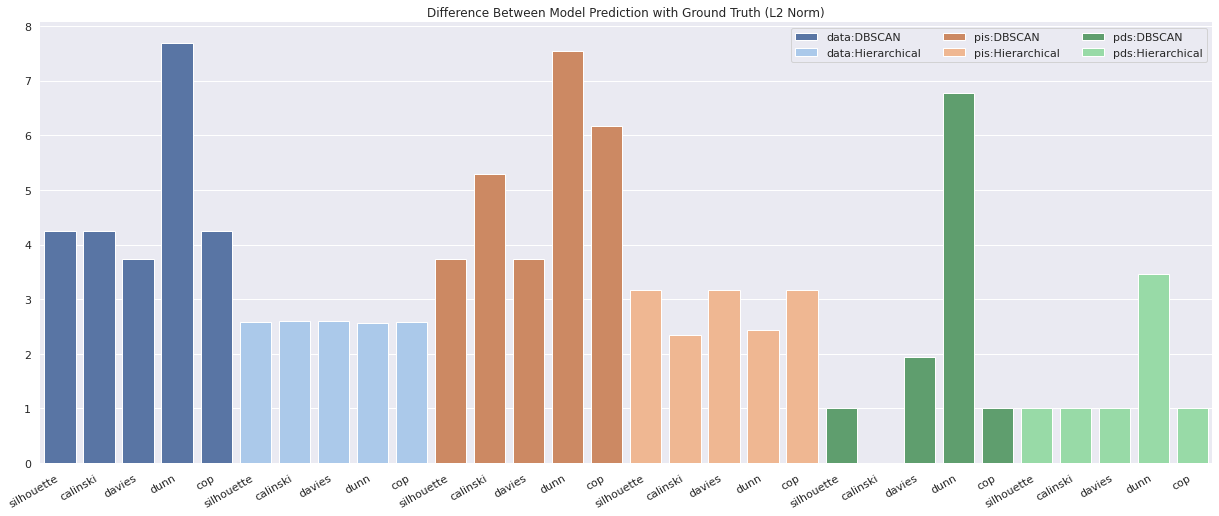

In [ ]:
oldModelName = list(L2norm.keys())
newModelName = []
for name in oldModelName:
    temp = name.split(':')[2:]
    newModelName.append(":".join(temp))

className = ['data:DBSCAN', 'data:Hierarchical', 'pis:DBSCAN', 'pis:Hierarchical', 'pds:DBSCAN', 'pds:Hierarchical']
className = np.repeat(className, 5)

data = {'modelName' : oldModelName,
        'largeClass' : className,
        'modelTargetL2Norm' : list(L2norm.values())}

df = pd.DataFrame(data)

sns.set_color_codes("pastel")
qualitative_colors_deep = sns.color_palette('deep')
qualitative_colors_light = sns.color_palette('pastel')
palette = {
    'data:DBSCAN' : qualitative_colors_deep[0],
    'data:Hierarchical' : qualitative_colors_light[0],
    'pis:DBSCAN' : qualitative_colors_deep[1],
    'pis:Hierarchical' : qualitative_colors_light[1],
    'pds:DBSCAN' : qualitative_colors_deep[2],
    'pds:Hierarchical' : qualitative_colors_light[2],
}

f, ax = plt.subplots(figsize=(21, 9))
ax = sns.barplot(x=oldModelName, y='modelTargetL2Norm', data=df, hue='largeClass', dodge=False, palette=palette)
#ax = sns.barplot(x=oldModelName, y='modelTargetL2Norm', data=df, hue='largeClass', dodge=False)
plt.title("Difference Between Model Prediction with Ground Truth (L2 Norm)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.legend(ncol=3, loc="upper right", frameon=True)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.set_xticklabels(newModelName)
#for p in ax.patches:
#    ax.annotate("%.2f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
#            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

sns.despine(left=True, bottom=True)
ax.get_figure().autofmt_xdate()
plt.savefig("test save.png")
files.download("test save.png") 

['Ground Truth']
data
silhouette,[0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0]
calinski,[0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0]
davies,[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
dunn,[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
cop,[0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0]
silhouette,[0 4 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
calinski,[0 4 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 2 0 0]
davies,[0 4 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 2 0 0]
dunn,[0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
cop,[0 4 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
pis
silhouette,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
calinski,[0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
davies,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
dunn,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
cop,[1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0

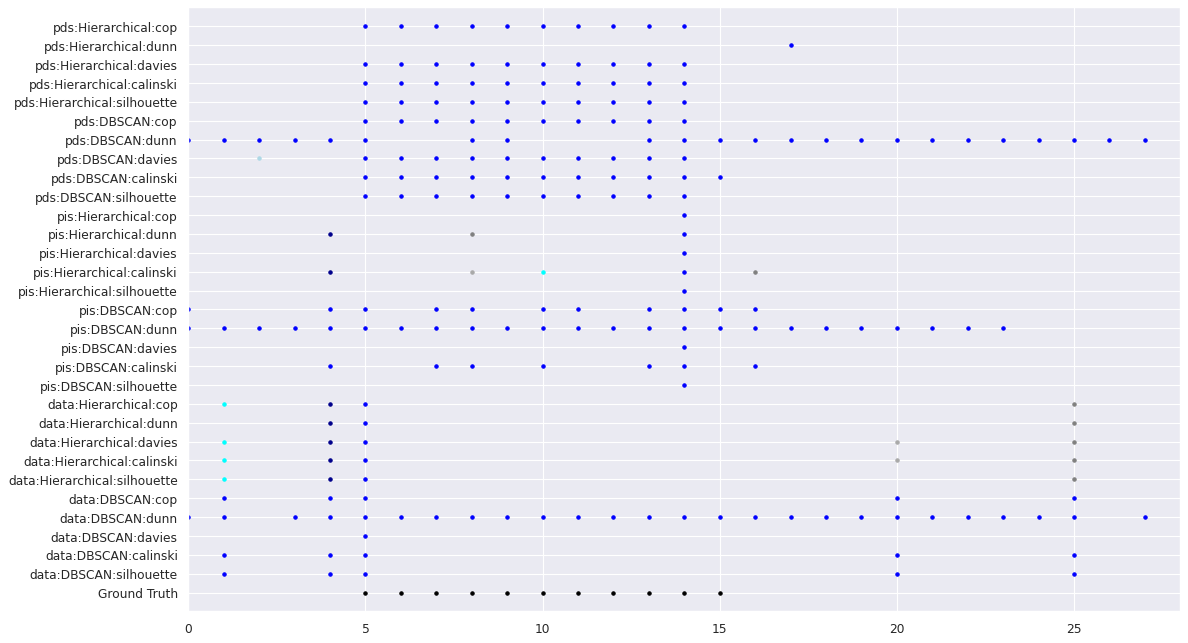

In [ ]:
i=0
labels=np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
      0, 0, 0, 0, 0, 0, 0], dtype='float64')
idx=np.where(labels==min(labels))
labels[idx]=np.nan
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(28),labels + i, linestyle="",marker=".", color='black')
yticks = ['Ground Truth']
print(yticks)
for data in clusters.keys():
 print(data)
 for method in clusters[data].keys():
  for key,clustering in clusters[data][method].items():
    i+=1    
    unique_labels=np.unique(clustering.labels_)
    #print(unique_labels)
    labels=np.array([1]*28, dtype='float32')
    if len(unique_labels)==2:
      clustering.labels_=np.abs(clustering.labels_)
      idx=np.where(clustering.labels_==min(clustering.labels_))   
      labels[idx]=np.nan
      plt.plot(range(len(labels)),labels + i, linestyle="",marker=".", color='blue')
    else:
      colors=['lightblue','yellow', 'blue','gray', 'darkblue', 'cyan', 'darkgray']
      for label in unique_labels:
        if label !=0:
          idx=np.where(clustering.labels_==label)
          labels[idx]=1
          plt.plot(idx[0],labels[idx] + i, linestyle="",marker=".", color=colors[label+1])

    #print(key + "," + str(labels))
    print(key + "," + str(clustering.labels_))
    yticks.append(data + ":" + method + ":" + key)
print ("Test for yticks: {}".format(yticks))
plt.xlim([0, 28])
plt.ylim([0, len(yticks)+1])
plt.yticks(range(1,len(yticks)+1), yticks)
plt.savefig("morse.pdf")
plt.show()

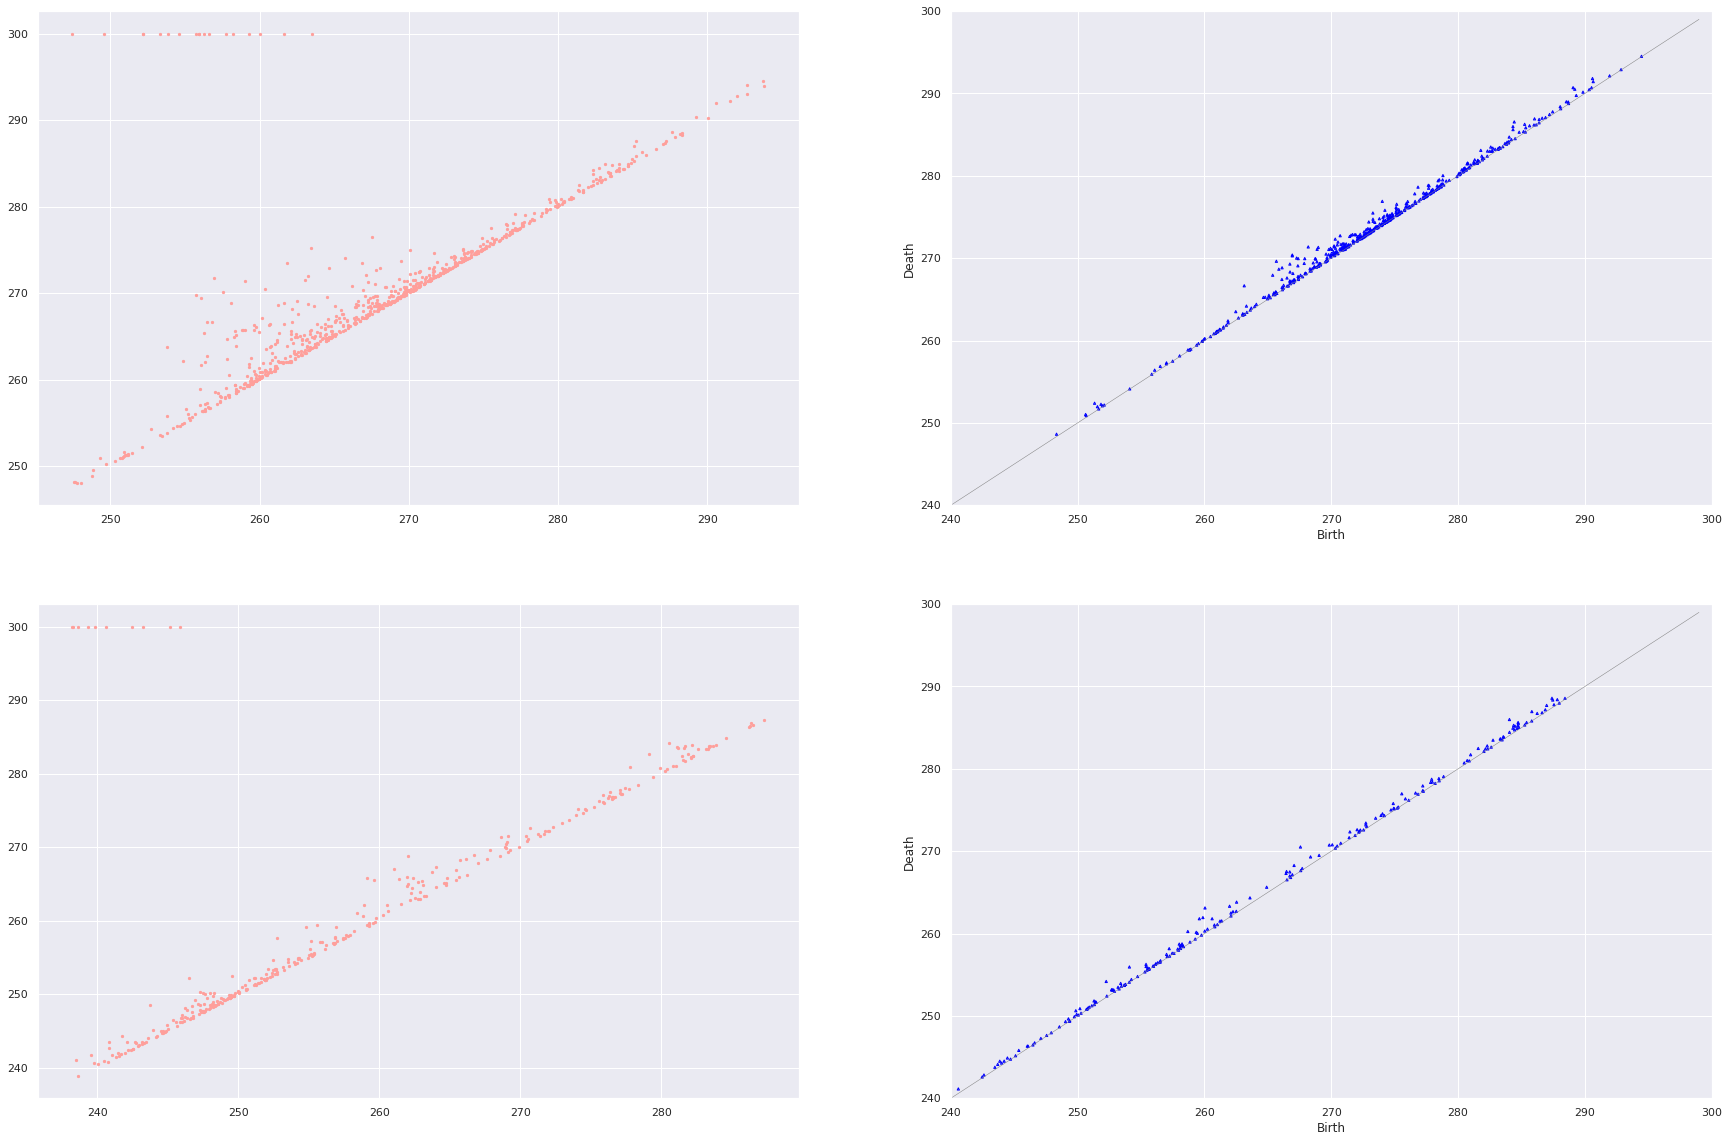

In [ ]:
#cluster_labels = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#       0, 0, 0, 0, 0])
plot_Dionysus_PDs_by_Cluster(pd0_union, pd1_union, titles, clustering.labels_)

In [ ]:
idx0= np.where(clustering.labels_==0)[0]
idx1= np.where(clustering.labels_!=0)[0]

In [ ]:
dim0_xs_cl0 = np.array([])
dim0_ys_cl0 = np.array([])
dim1_xs_cl0 = np.array([])
dim1_ys_cl0 = np.array([])
for day in idx0:
    dim0_xs_cl0= np.concatenate((dim0_xs_cl0, pd0_union[day][0]))
    dim0_ys_cl0= np.concatenate((dim0_ys_cl0, pd0_union[day][1]))
    dim1_xs_cl0= np.concatenate((dim1_xs_cl0, pd1_union[day][0]))
    dim1_ys_cl0= np.concatenate((dim1_ys_cl0, pd1_union[day][1]))

In [ ]:
dim0_xs_cl1 = np.array([])
dim0_ys_cl1 = np.array([])
dim1_xs_cl1 = np.array([])
dim1_ys_cl1 = np.array([])
for day in idx1:
    dim0_xs_cl1= np.concatenate((dim0_xs_cl1, pd0_union[day][0]))
    dim0_ys_cl1= np.concatenate((dim0_ys_cl1, pd0_union[day][1]))
    dim1_xs_cl1= np.concatenate((dim1_xs_cl1, pd1_union[day][0]))
    dim1_ys_cl1= np.concatenate((dim1_ys_cl1, pd1_union[day][1]))

In [ ]:
mydict0x = {'Normal': dim0_xs_cl0, 'Outlier': dim0_xs_cl1}
 
dict_df0x = pd.DataFrame({ key:pd.Series(value) for key, value in mydict0x.items() })

mydict0y = {'Normal': dim0_ys_cl0, 'Outlier': dim0_ys_cl1}
 
dict_df0y = pd.DataFrame({ key:pd.Series(value) for key, value in mydict0y.items() })

mydict1x = {'Normal': dim1_xs_cl0, 'Outlier': dim1_xs_cl1}
 
dict_df1x = pd.DataFrame({ key:pd.Series(value) for key, value in mydict1x.items() })

mydict1y = {'Normal': dim1_ys_cl0, 'Outlier': dim1_ys_cl1}
 
dict_df1y = pd.DataFrame({ key:pd.Series(value) for key, value in mydict1y.items() })

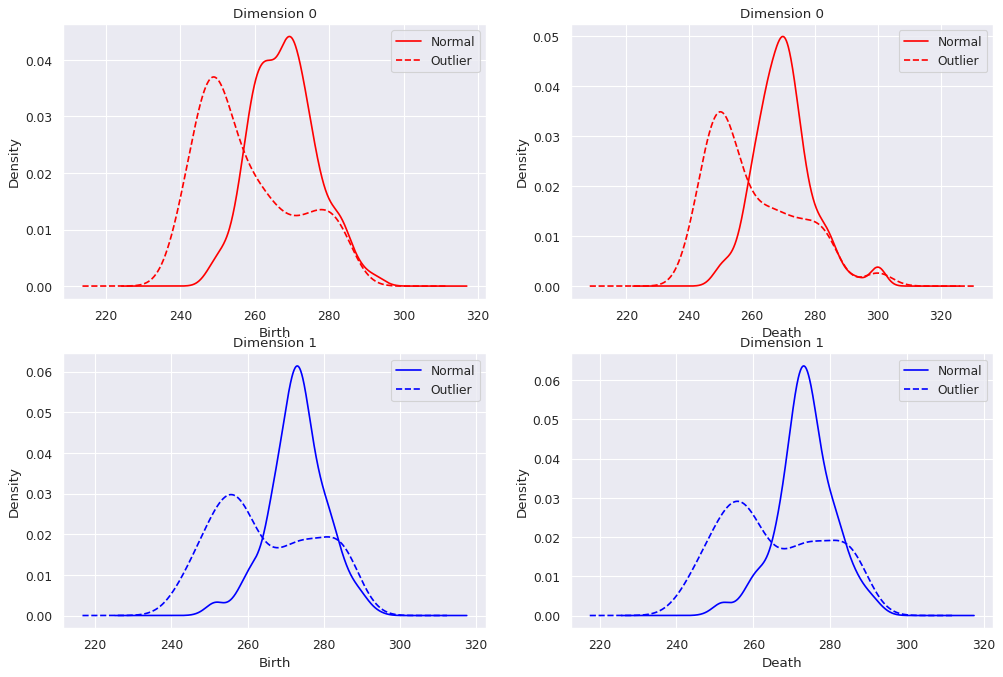

In [ ]:
#plt.figure(num=None, figsize=(25, 15), dpi=80, facecolor='w', edgecolor='k')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), dpi=80)

#pd_dim0_xs_cl0.plot(kind = "hist", density = True, bins = 50) # change density to true, because KDE uses density
dict_df0x.plot(ax=axes[0,0],kind = "kde", title="Dimension 0", color='red', style=['-','--'])
axes[0,0].set_xlabel("Birth")
#pd_dim0_xs_cl0.plot(kind = "hist", density = True, bins = 50) # change density to true, because KDE uses density
dict_df0y.plot(ax=axes[0,1], kind = "kde", title="Dimension 0", color='red', style=['-','--'])
axes[0,1].set_xlabel("Death")
dict_df1x.plot(ax=axes[1,0],kind = "kde", title="Dimension 1", color='blue', style=['-','--'])
axes[1,0].set_xlabel("Birth")
#pd_dim0_xs_cl0.plot(kind = "hist", density = True, bins = 50) # change density to true, because KDE uses density
dict_df1y.plot(ax=axes[1,1], kind = "kde", title="Dimension 1", color='blue', style=['-','--'])
axes[1,1].set_xlabel("Death")
plt.savefig('clusters_2norm.pdf', bbox_inches='tight')
plt.show()